# Module 4 Final Project

## Time Series Analysis

Name: Hazel Donaldson <br>
Pace: Part-time <br>
Review Date: <br>
Instructor Name: Victor Geislinger <br>

## 1. Introduction
In this project, I will be performing a time series analysis on historical housing data obtained from Zillow. I will be looking for the top 5 zipcodes a real estate developer should invest in (buy homes, renovate and rent to people). This investor is looking for busy, dense metropolitan areas with average house prices around the median. 

## 2. Libraries and Functions

In [1]:
# import necessary libraries for EDA, visualization and time series analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
import itertools 
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# add functions here
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

def acf_pacf(df, alags=48, plags=48):
    #Create figure
    fig,(ax1, ax2) = plt.subplots(2,1, figsize=(13,8))
    #Create ACF plot
    plot_acf(df, lags=alags, zero=False, ax=ax1)
    #PACF plot
    plot_pacf(df, lags=plags, ax=ax2)
    plt.show()
    
def seasonal_plot(df, N=13, lags=[12,24,36,48,60,72]):
    #differencing the rolling mean to find seasonality in acf plot
    fig,(ax1, ax2) = plt.subplots(2,1,figsize=(13,8))
    rolling = TS_80631 - TS_80631.rolling(N).mean()
    plot_acf(rolling.dropna(), lags=lags, ax=ax1)
    plot_pacf(rolling.dropna(), lags=lags, ax=ax2)
    plt.show();

def AIC(zipcode):
    ans = []
    global output
    global mod
    for comb in pdq:
        for combs in pdqs:
            try: 
                mod = sm.tsa.statespace.SARIMAX(zipcode,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue
    
def train_test(df):
    train = df[:'2015-04']
    test = df['2015-05':]
    return train, test

def model_fit(df, pdq=(1,0,1), pdqs=(0,0,0,1)):
    train, test = train_test(df)
    model = SARIMAX(train, order= pdq, seasonal=pdqs)
    results = model.fit()
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show()
    return train, test, results

def test_RMSE(df,pdq=(1,0,1),pdqs=(0,0,0,1), display=True):
    X = df.values
    train, test = X[:-36],X[-36:]
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = SARIMAX(history, order=pdq,seasonal_order=pdqs)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(MSE(test, predictions))
    print('SARIMA model RMSE on test data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        plt.title('Actual Test Data vs. Predictions')
        plt.plot(history[-36:],label='Actual', color='b')
        plt.plot(predictions,label='Predictions',color='r')
        plt.legend(loc='best')
        plt.show()

def train_RMSE(train, results, display = True):
    train_pred = results.predict(-36)
    rmse = sqrt(MSE(train[-36:],train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        train[-60:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='r')
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predicted Returns')
        plt.show()
        
def forecast_model(df, pdq=(1,0,1), pdqs=(0,0,0,1), display=True, zc='input zipcode'):
    model = SARIMAX(df, order=pdq, seasonal_order=pdqs)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04', end='2028-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:, 1],
                       color= 'k', alpha=.25, label='Confidence Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_3=(1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    tot_ret = [zc,year_1,year_3,year_5,year_10]
    return tot_ret

## 3. Import dataset

In [3]:
zillow_df = pd.read_csv('zillow_data.csv')
print(zillow_df.info(), '\n')
print(f'Unique amount of zipcodes: {zillow_df.RegionName.nunique()}')
zillow_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB
None 

Unique amount of zipcodes: 14723


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [ ]:
zillow_df.describe()

Looking at our data set, I can see that it is provided in wide-format. Further down, I will transform the data set into long format so that it is easier to read. There are 14,723 unique zipcodes in the data, so the next step will be to select the zipcodes that fit the investor's interests.

## 4. Data Preprocessing

In [4]:
# Find the zipcodes that are in highly urbanized areas
print(zillow_df.SizeRank.describe())
#Calculate 20% cutoff point
srank_20 = zillow_df.SizeRank.quantile(q=0.20)
print(f'Size Rank 20% cutoff value: {srank_20}')
#New dataframe
top_20_zc = zillow_df[zillow_df['SizeRank'] < srank_20].drop(['RegionID','City','State','Metro','CountyName','SizeRank'],axis=1)
print(f'Amount of zipcodes: {len(top_20_zc)}')

count    14723.000000
mean      7362.000000
std       4250.308342
min          1.000000
25%       3681.500000
50%       7362.000000
75%      11042.500000
max      14723.000000
Name: SizeRank, dtype: float64
Size Rank 20% cutoff value: 2945.4
Amount of zipcodes: 2945


The number of zipcodes has been narrowed down to 2,945 from 14,723. Now I will narrow down the zipcodes to housing prices that hover around the median price. The average value will be calculated from last year's data as this the data the investor is mostly likely to encounter.

In [5]:
top_20_zc['yr_avg'] = top_20_zc.iloc[:,-12:].mean(skipna=True, axis=1)
print(top_20_zc['yr_avg'].describe())
q_60 = top_20_zc['yr_avg'].quantile(q=0.60)
q_35 = top_20_zc['yr_avg'].quantile(q=0.35)
print(f'Average Value for 60% cutoff rate: {round(q_60, 2)}')
print(f'Average Value for 35% cutoff rate: {round(q_35, 2)}')
pref_zc = top_20_zc[(top_20_zc['yr_avg'] < q_60) & (top_20_zc['yr_avg'] > q_35)]
print(f'Amount of zipcodes: {len(pref_zc)}')

count    2.945000e+03
mean     3.730666e+05
std      5.836511e+05
min      3.632500e+04
25%      1.691333e+05
50%      2.484083e+05
75%      3.978333e+05
max      1.858138e+07
Name: yr_avg, dtype: float64
Average Value for 60% cutoff rate: 290211.67
Average Value for 35% cutoff rate: 198641.67
Amount of zipcodes: 736


The number of zipcodes to consider is now 736. This takes in some of the requirements the investor is looking for: urbanization and median home value. Now, its time to look at things from an investment standpoint and calculate the return on investment and the coefficient of variance to take into account the risks involved. The return on investment or ROI is percentage increase in price. I will be calculating the ROI  between 2013-2018. This will represent the areas with the highest recent price uptrend. 

On the other hand, the investor will want to select areas where there is low volatility. It lowers risks when housing prices drop. The coefficient of variance is also used here, it's defined by the standard deviation divided by the mean. All 22 years of data is used here and null values are skipped. The higher the coefficient, the more volatile the zipcode.

In [6]:
pref_zc['roi'] = (pref_zc['2018-04']- pref_zc['2013-01'])/pref_zc['2013-01']
#calculate the standard deviation of monthly values
pref_zc['std'] = pref_zc.loc[:,'1996-04': '2018-04'].std(skipna=True, axis=1)
#calculate historic mean
pref_zc['mean'] = pref_zc.loc[:, '1996-04': '2018-04'].mean(skipna=True, axis=1)
#calculate the coefficient of variance
pref_zc['CV'] = pref_zc['std']/pref_zc['mean']
#show calculated values
pref_zc[['RegionName', 'std', 'roi', 'CV']].head(10)

,RegionName,std,roi,CV
11,32162,53805.394161,0.227694,0.292910
14,37013,19771.938500,0.696557,0.142048
17,37211,36496.608464,0.798502,0.247623
18,78660,24894.592870,0.437537,0.148012
22,77573,29647.359699,0.412973,0.161776
23,77584,27064.756641,0.378291,0.143482
31,78130,23349.861603,0.410077,0.152247
38,77429,25209.719327,0.397936,0.141715
45,77433,28113.378077,0.335095,0.148727
51,30043,24035.181933,0.648415,0.142436


In [7]:
#descriptive statistics for coefficient of variance
print(pref_zc['CV'].describe())
#define an upper limit for CV
upper_cv = pref_zc.CV.quantile(q=0.60)
print(f'Upper CV limit: {upper_cv}')
#get zipcodes with highest ROIs within risk profile
best_zc = pref_zc[pref_zc.CV < upper_cv].sort_values('roi', ascending=False, axis=0)[:5]
best_zc[['RegionName', 'roi', 'CV']].head(20)

count    736.000000
mean       0.238700
std        0.080020
min        0.056119
25%        0.171094
50%        0.226459
75%        0.291877
max        0.453303
Name: CV, dtype: float64
Upper CV limit: 0.25459687610566145


,RegionName,roi,CV
1235,80631,1.037433,0.239795
2419,97233,0.983516,0.248805
422,78758,0.898876,0.228653
2693,98444,0.832353,0.244243
2005,37214,0.811351,0.216641


In [8]:
#get location names
best_zipcodes = list(best_zc.RegionName.values)
for i in best_zipcodes:
    city = zillow_df[zillow_df['RegionName']== i].City.values[0]
    state = zillow_df[zillow_df['RegionName'] == i].State.values[0]
    print(f'Zipcode: {i}\n Location: {city}, {state}\n')

Zipcode: 80631
 Location: Greeley, CO

Zipcode: 97233
 Location: Portland, OR

Zipcode: 78758
 Location: Austin, TX

Zipcode: 98444
 Location: Parkland, WA

Zipcode: 37214
 Location: Nashville, TN



The data is still formatted in a wide format, with each month as a column. In order to perform a time series analysis, it needs to be formatted in long format, with month as a row.

In [9]:
TS_ZC5 = best_zc.drop(['yr_avg', 'std', 'mean', 'roi', 'CV'], axis=1)
TS_ZC5 =melt_data(TS_ZC5).set_index('time')
print('Time Series Data for top 5 zipcodes:\n', TS_ZC5.head())
dfs_ts = []
for zc in TS_ZC5.RegionName.unique():
    df = TS_ZC5[TS_ZC5['RegionName']==zc].asfreq('MS')
    dfs_ts.append(df)
dfs_ts[0].head()

Time Series Data for top 5 zipcodes:
             RegionName     value
time                            
1996-04-01       80631   86500.0
1996-04-01       97233  110800.0
1996-04-01       78758  129000.0
1996-04-01       98444  100400.0
1996-04-01       37214   88300.0


,RegionName,value
time,,
1996-04-01,80631,86500.0
1996-05-01,80631,87000.0
1996-06-01,80631,87500.0
1996-07-01,80631,87900.0
1996-08-01,80631,88400.0


## EDA and Visualization

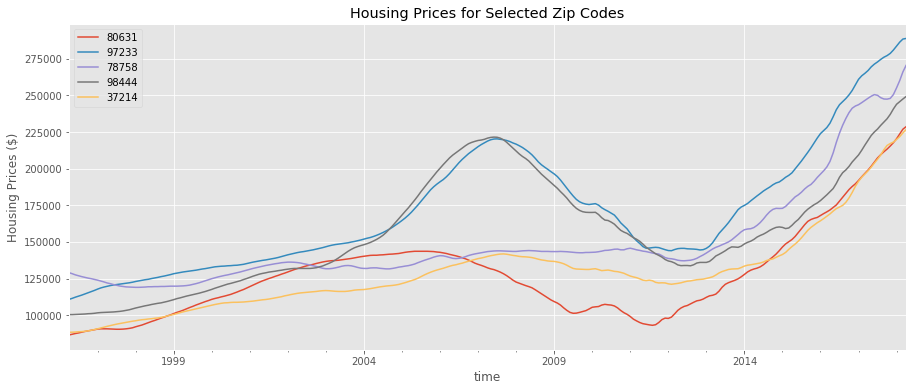

In [10]:
for i in range(5):
    dfs_ts[i].value.plot(label=dfs_ts[i].RegionName[0], figsize=(15,6))
    plt.title('Housing Prices for Selected Zip Codes')
    plt.ylabel('Housing Prices ($)')
    plt.legend()

The graph above shows the prices are about the same for the 22 year period and I can see that the housing trends for Portland (97233) and Parkland(98444) got higher and fell around the time of the great housing crash and recession of 2009. There is a bit of the a dip in the Greeley(80631) trend around the time of the housing crash. 

In [11]:
for i in range(len(dfs_ts)):
    print(f'Value descriptive statistics for zipcode {dfs_ts[i].RegionName[0]}:')
    print(f'{dfs_ts[i].value.describe()}\n')

Value descriptive statistics for zipcode 80631:
count       265.000000
mean     127692.075472
std       30619.962378
min       86500.000000
25%      105000.000000
50%      123900.000000
75%      140900.000000
max      228600.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 97233:
count       265.000000
mean     171571.698113
std       42687.913348
min      110800.000000
25%      139400.000000
50%      158900.000000
75%      199100.000000
max      288800.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 78758:
count       265.000000
mean     149549.056604
std       34194.863952
min      119000.000000
25%      131900.000000
50%      139900.000000
75%      145000.000000
max      270400.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 98444:
count       265.000000
mean     157524.528302
std       38474.187065
min      100400.000000
25%      130400.000000
50%      150600.000000
75%      186400.000000
max     

## Time Series Modeling

Since most of the prices in the housing trend graph above are similar, we will need a better way to compare the zipcodes. We will look at the monthly returns because the returns are comparable to each other and prices are dependent to the previous price.

In [12]:
# new column for monthly returns
for zc in range(len(dfs_ts)):
    dfs_ts[zc]['ret'] = np.nan *len(dfs_ts)
    for i in range(len(dfs_ts[zc])-1):
        dfs_ts[zc]['ret'][i+1] = (dfs_ts[zc].value.iloc[i+1]/dfs_ts[zc].value.iloc[i]) - 1

Before we can begin modeling, an important assumption needs to be confirmed: stationary. Stationary tells us that the mean is constant, the standard deviation is constant and there is not seasonality.

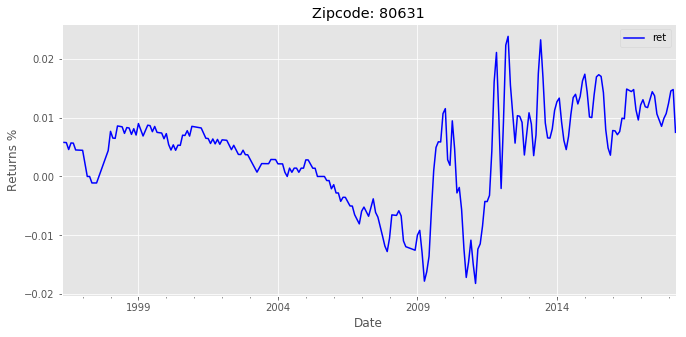

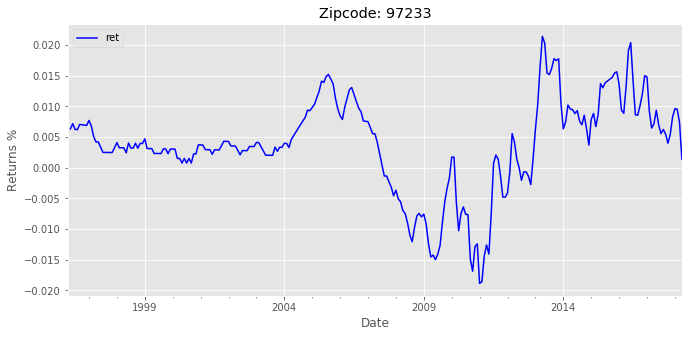

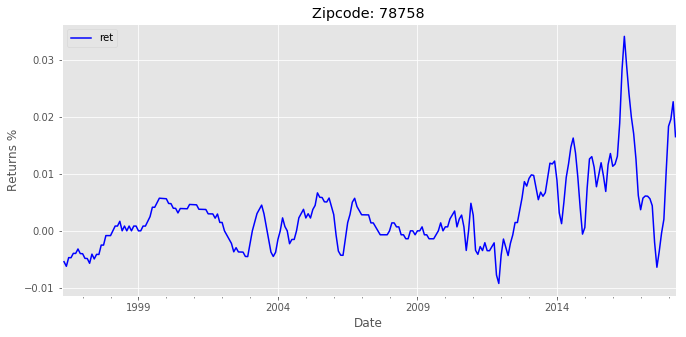

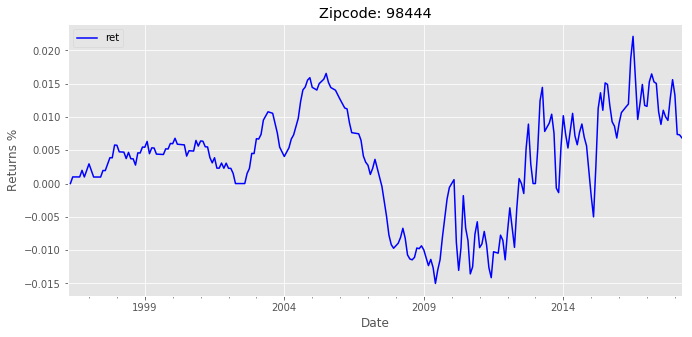

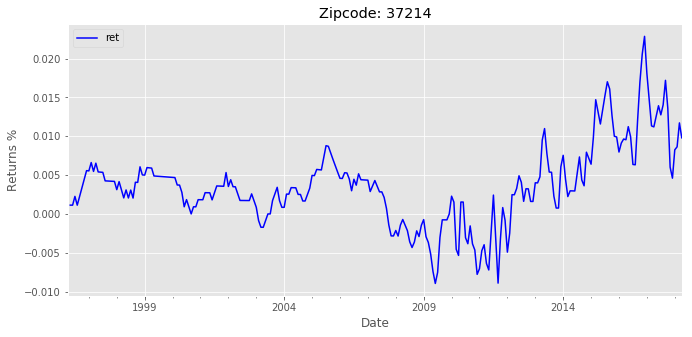

In [13]:
#plot the monthly returns for each zipcode
for i in range(len(dfs_ts)):
    dfs_ts[i].ret.plot(figsize=(11, 5), color = 'b')
    plt.title(f'Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns %')
    plt.legend(loc='best')
    plt.show()

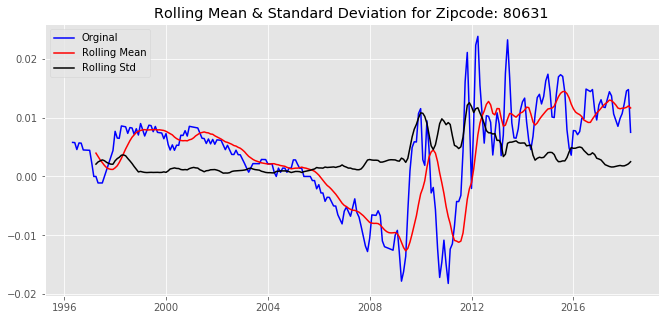

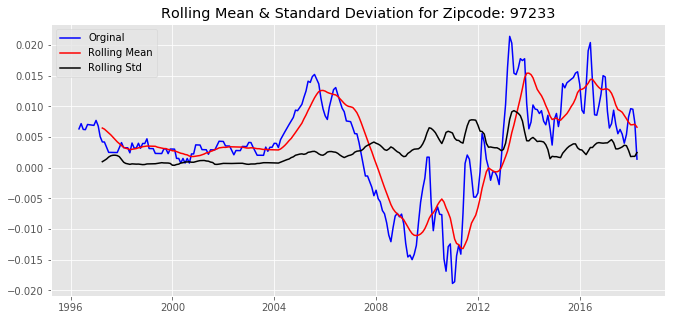

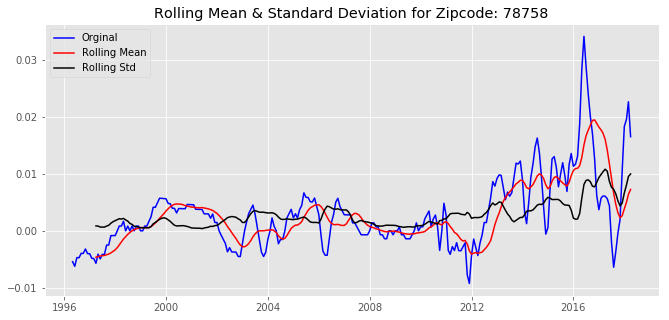

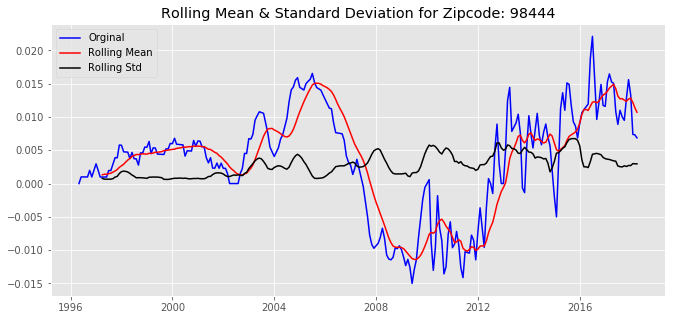

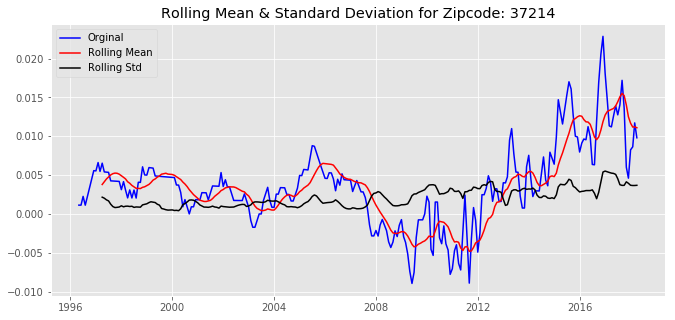

In [14]:
for i in range(len(dfs_ts)):
    rolmean= dfs_ts[i].ret.rolling(window=12, center=False).mean()
    rolstd = dfs_ts[i].ret.rolling(window=12, center=False).std()
    fig = plt.figure(figsize=(11, 5))
    orig = plt.plot(dfs_ts[i].ret,color='blue',label='Orginal')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.show()

Visually, the data seems to not be stationary. However, we will challenge this visualizations using the Dickey-Fuller test and confirm whether or not the data is truly stationary. The Dickey-Fuller test is a statistical test of stationary in a time series. The null hypothesis of the Dickey-Fuller test say that the data is not stationary and the alternative hypothesis says the data is stationary. We will set the confidence level to 95% and we will reject the null hypothesis if there is p-value greater than 0.05.

In [15]:
for i in range(5):
    results = adfuller(dfs_ts[i].ret.dropna())
    print(f'ADFuller test p-value for stationary: {dfs_ts[i].RegionName[0]}')
    print('P-value',results[1])
    if results[1] > 0.05:
        print('Fail to reject the null hypothesis. The data is not stationary.\n')
    else:
        print('Reject the null hypothesis. The data is stationary.\n')

ADFuller test p-value for stationary: 80631
P-value 0.710539628008088
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 97233
P-value 0.11396395166248763
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 78758
P-value 0.17369935135771158
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 98444
P-value 0.3107084009520179
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 37214
P-value 0.5467030124705775
Fail to reject the null hypothesis. The data is not stationary.



As we can see above, none of the zipcodes are stationary and will need to take the first difference to see the effect on stationary.

In [16]:
#take the order of intergration
for i in range(5):
    results = adfuller(dfs_ts[i].ret.diff().dropna())
    print(f'ADFuller test p-value for stationary: {dfs_ts[i].RegionName[0]}')
    print('P-value',results[1])
    if results[1] > 0.05:
        print('Fail to reject the null hypothesis. The data is not stationary.\n')
    else:
        print('Reject the null hypothesis. The data is stationary.\n')

ADFuller test p-value for stationary: 80631
P-value 6.064327655106482e-10
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 97233
P-value 4.884612558355817e-08
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 78758
P-value 8.497498344953488e-09
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 98444
P-value 0.0006377881980377828
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 37214
P-value 2.7102862556018217e-07
Reject the null hypothesis. The data is stationary.



By taking the first difference of the data, all the data is now stationary. Moving forward, the I or integration for the ARIMA or SAMIRA model will be one. 

In [17]:
#create individual times series for each zipcode
TS_80631 = dfs_ts[0].ret.dropna() #zipcode 80631 monthly returns time series
TS_80631d = dfs_ts[0].ret.diff().dropna() # differenced time series

TS_97233 = dfs_ts[1].ret.dropna()
TS_97233d = dfs_ts[1].ret.diff().dropna()

TS_78758 = dfs_ts[2].ret.dropna()
TS_78758d = dfs_ts[2].ret.diff().dropna()

TS_98444 = dfs_ts[3].ret.dropna()
TS_98444d = dfs_ts[3].ret.diff().dropna()

TS_37214 = dfs_ts[4].ret.dropna()
TS_37214d = dfs_ts[4].ret.diff().dropna()

## Zipcode: 80631 (Greeley, CO)

To begin, I will plot the ACF and PACF to find the p and q parameter of this zipcode's ARIMA model. We have previously found the 'I' parameter to be 1 when we took the first difference.

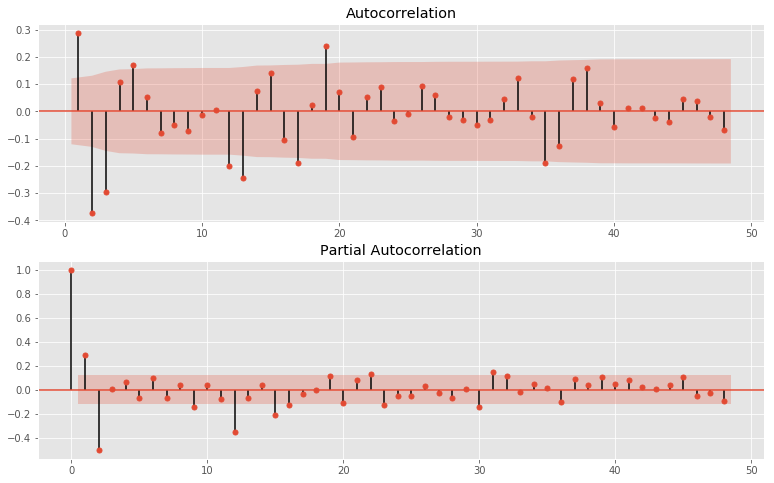

In [18]:
acf_pacf(TS_80631d)

From the plots, we can see that the ACF has 1 positive lag and two negative lags that are statistically significant so the MA(q) parameter is 1. The AR(p) is 2 or 3. Now, let's check for seasonality in the returns.

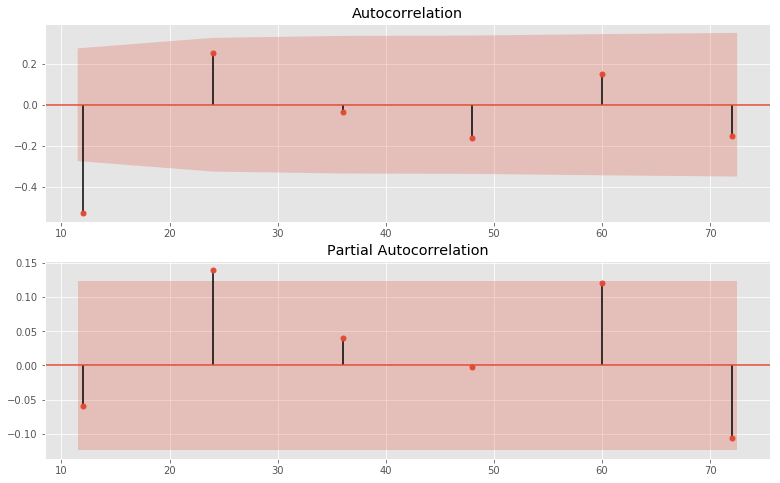

In [19]:
seasonal_plot(TS_80631d, N=13)

As we can see, there is a statistically significant lag at 12 in the autocorrelation plot and a slight statistically significant lag at 24 months in the partial autocorrelation plot which lends credence to the fact that there is seasonality in the data. So, we can move forward with seasonal ARIMA model or SARIMA model. The ARIMA model is the most common method in time series analysis, which stands for Auto-Regressive Integrated Moving Average.

The ARIMA model has three components: AR (auto-regression, the p-value) component allows us to incorporate the effect of past values on our model. For example, the price of flowers may be high because the price of flowers has been high for the past few months. The AR terms are lags of the dependent variable. For instance, if p is 5, the predictors of x(t) will be x(t-1)...x(t-5). 
Number of differences of integration (d-value) is the value of the amount of differencing as it identifies the number of lags to subtract from the current observations. This is similar to saying that price of flowers is likely to be high because the difference in the price of flowers in the last couple of months was small. 
The MA(moving average: q-value) component of the model is a linear combination of error values observed at different points in the past. For instance if the q-value in a model is 2, then x(t)'s predictors are e(t-1) and e(t-2). The term s is the periodicity of the time series(4 is quarterly periods and 12 is annual periods).

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

The AIC value or Akaike Information Criterion provided by the statsmodels library. AIC is an estimator of the relative quality of the statistical model of a given data set and provides a mean of model selection. A model with many features that fits the data well will be assigned a larger AIC value than a model with fewer features to acheive the same goodness of fit. Therefore, we are interested in a lowest AIC value possible.

In [ ]:
for param in pdq:
    for param_season in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_80631, order = param,
                                           seasonal_order = param_season,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA {}x{}12 - AIC:{}'.format(param, param_season, results.aic))
        except:
            continue

In [ ]:
def AIC(zipcode):
    ans = []
    global output
    global mod
    for comb in pdq:
        for combs in pdqs:
            try: 
                mod = sm.tsa.statespace.SARIMAX(zipcode,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue
    # Find the parameters with minimal AIC value.

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
AIC(TS_80631)

From the code above, we see our ARIMA parameters are p = 1, q=1 and P = 1, Q = 1. From previous AD Fuller tests, we found that the data wasn't stationary and therefore the 'I' in the SARIMA model is one. Let's proceed to see if these paramaters fit our model.

In [20]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [21]:
from pmdarima.arima import auto_arima

In [22]:
results = auto_arima(TS_80631, information_criterion='aic',m=12,d=0,
                         start_p=1,start_q=1, max_p=3, max_q=3,
                         stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=-2380.690, BIC=-2359.234, Fit time=2.169 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-1793.170, BIC=-1786.019, Fit time=0.141 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-2217.289, BIC=-2202.985, Fit time=0.812 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-2095.230, BIC=-2080.926, Fit time=1.680 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-2380.226, BIC=-2362.346, Fit time=1.632 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 1, 12); AIC=-2379.395, BIC=-2354.363, Fit time=6.678 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=-2380.776, BIC=-2362.897, Fit time=1.922 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=-2108.818, BIC=-2094.514, Fit time=1.101 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=-2328.921, BIC=-2307.465, Fit time=2.963 seconds
Fit ARIMA:

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1016.616
Date:                Thu, 17 Oct 2019   AIC                          -2027.232
Time:                        09:42:59   BIC                          -2016.958
Sample:                    05-01-1996   HQIC                         -2023.086
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0606      0.092     -0.662      0.508      -0.240       0.119
ma.L1          0.5327      0.093      5.710      0.000       0.350       0.716
sigma2      7.517e-06   4.54e-07     16.544      0.0

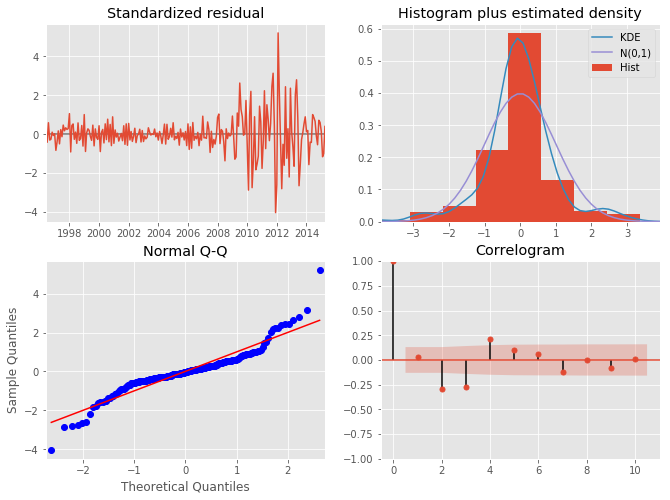

In [23]:
# fit SARIMA model
pdq = (1,1,1)
pdqs = (1,0,0,12)
train, test, results = model_fit(TS_80631, pdq=pdq, pdqs=pdqs)

 From the above plots, we can see that the KDE curve is relatively close to the N(0,1) curve which indicates that the residuals are normally distributed. The Q-Q plot also shows us that the residuals are normally distributed because the blue dots(the residuals) are along the red line(normal distribution). The graph at the top left, doesn't show any obvious seasonality and appears to be white noise.This is confirmed with the graph at the bottom right because the time series residuals have a low correlation with lagged verisons of themselves.

SARIMA model RMSE on train data: 0.00365


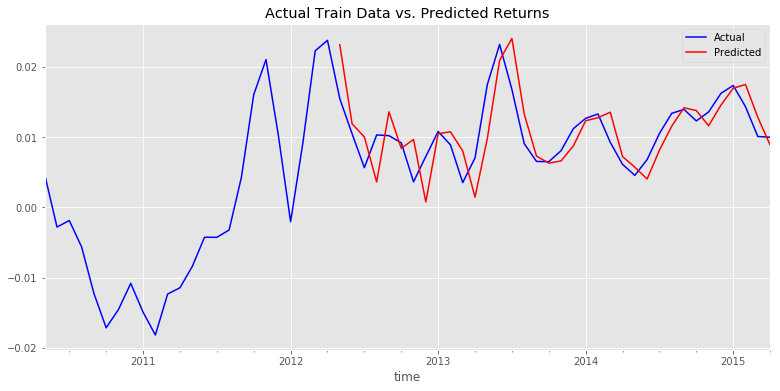

In [24]:
train_RMSE(train, results)

C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

SARIMA model RMSE on test data: 0.00254


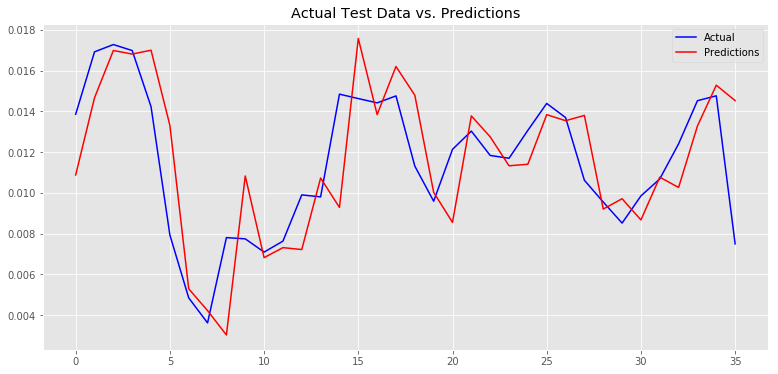

In [25]:
test_RMSE(TS_80631, pdq=pdq, pdqs=pdqs, display = True)

As we can see, the RMSEs for both are small but do not really fit the data well. However, the prediction plots follow a similar pattern to the actual data. Now we can calculate the out of sample forecasts to predict the total returns in one year, three years and five years. This process will be repeated for the four remaining zipcodes.

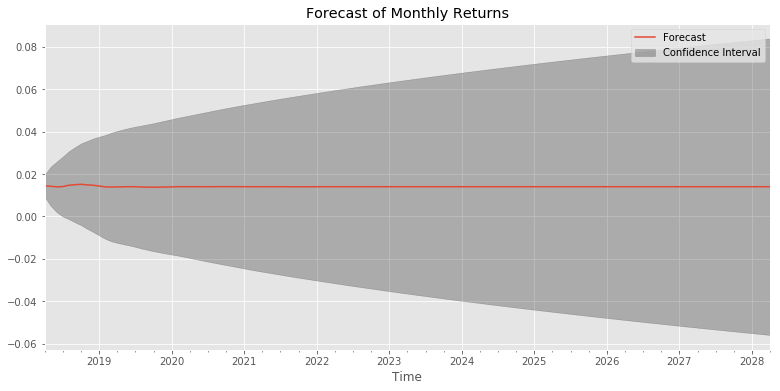

Total expected return in 1 year: 18.82%
Total expected return in 3 years: 65.93%
Total expected return in 5 year: 131.91%
Total expected return in 10 years: 443.09%


In [26]:
ret_80631 = forecast_model(TS_80631, pdq=pdq, pdqs=pdqs, zc = 80631)

## Zipcode 97233(Portland, OR)

Like the previous data, the data was not stationary so the plots for the ACF and PACF will be done with differenced data. The 'I' in the model will also be one.

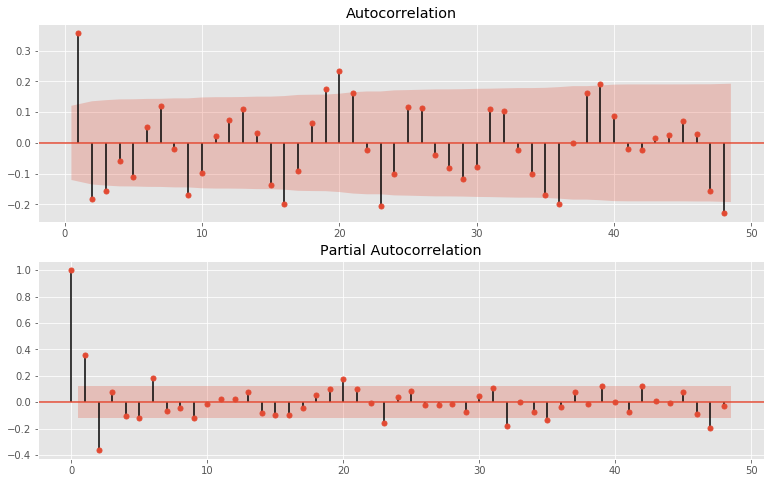

In [27]:
acf_pacf(TS_97233d)

From these plots, we can see the lags are tailing off and there will be AR & MA parameters in our model.

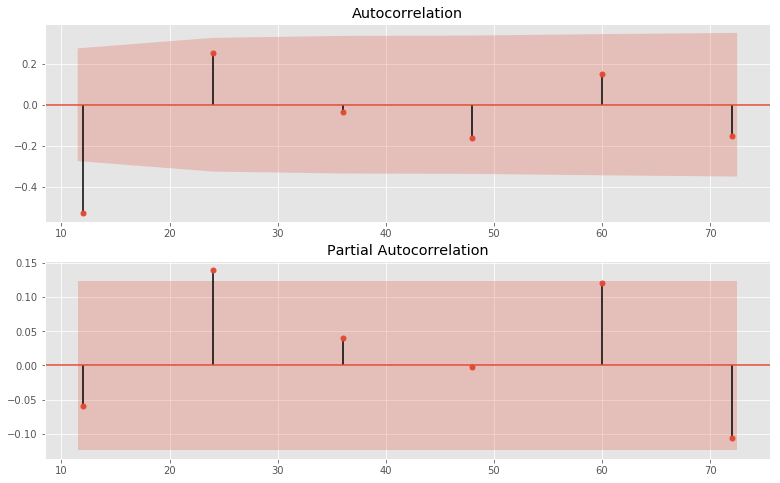

In [28]:
seasonal_plot(TS_97233d, N=13)

We can see that there is only one statistically significant lag at 12 months but this doesn't seem to be repeated at other 12 month intervals so it is possible there is no seasonality in the data.

In [29]:
results = auto_arima(TS_97233, information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=-2564.288, BIC=-2542.833, Fit time=2.182 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-1821.406, BIC=-1814.254, Fit time=0.217 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-2422.875, BIC=-2408.571, Fit time=0.752 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-2194.342, BIC=-2180.038, Fit time=1.097 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-2565.784, BIC=-2547.904, Fit time=3.148 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=-2567.314, BIC=-2553.010, Fit time=0.417 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=-2127.884, BIC=-2117.156, Fit time=0.334 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=-2503.807, BIC=-2485.928, Fit time=0.230 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-2499.098, BIC=-2488.371, Fit time=0.311 seconds
Fit ARIMA:

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_97233,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]


In [ ]:
AIC(TS_97233)

From the following SARIMA model parameters are: p = 1, d = 1, q = 1; P = 0, Q = 0. Let's proceed with fit these parameters to the model.

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1110.570
Date:                Thu, 17 Oct 2019   AIC                          -2215.140
Time:                        09:44:31   BIC                          -2204.865
Sample:                    05-01-1996   HQIC                         -2210.994
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2302      0.103     -2.225      0.026      -0.433      -0.027
ma.L1          0.7200      0.064     11.288      0.000       0.595       0.845
sigma2      3.288e-06    1.8e-07     18.314      0.0

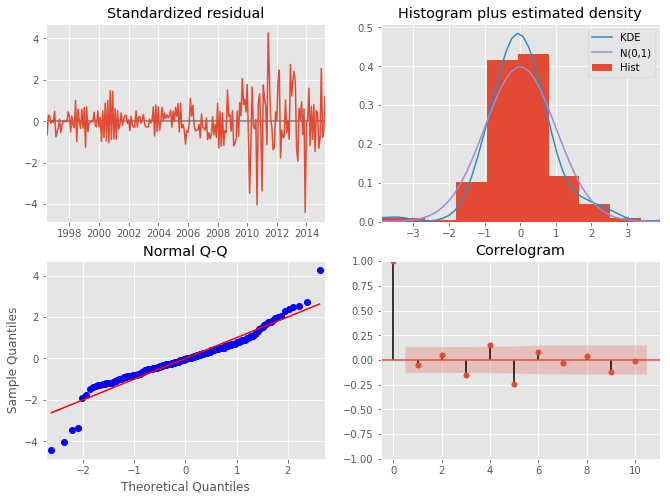

In [30]:
# fit SARIMA model
pdq = (1,1,1)
pdqs = (0,0,0,12)
train, test, results = model_fit(TS_97233, pdq=pdq, pdqs=pdqs)

It looks like the residuals looks normally distributed and signal looks mostly like white noise.

SARIMA model RMSE on train data: 0.00256


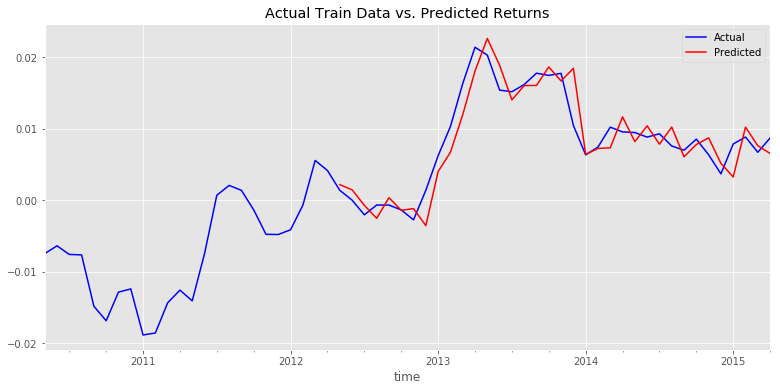

In [31]:
train_RMSE(train, results)

C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

SARIMA model RMSE on test data: 0.00239


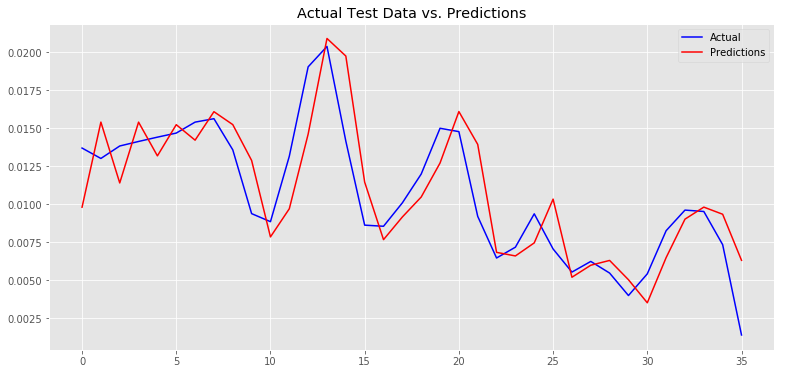

In [32]:
test_RMSE(TS_97233, pdq=pdq, pdqs=pdqs, display = True)

The RMSEs are small but the test data's RMSE is smaller. We can see that the predictions follows the actual data but is not exact.

C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


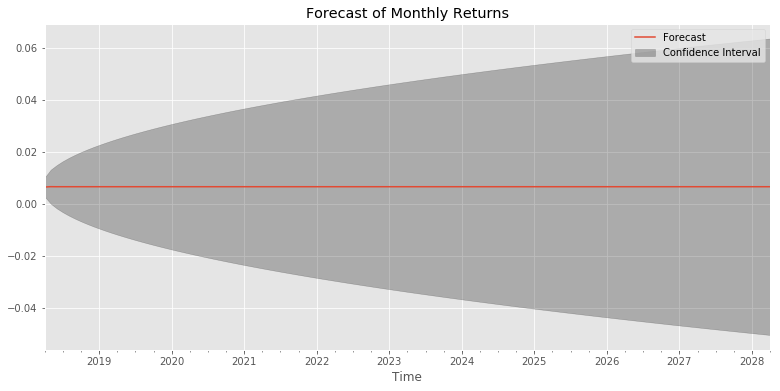

Total expected return in 1 year: 8.09%
Total expected return in 3 years: 26.32%
Total expected return in 5 year: 47.63%
Total expected return in 10 years: 119.38%


In [33]:
ret_97233 = forecast_model(TS_97233, pdq=pdq, pdqs=pdqs, zc = 97233)

## Zipcode 78758(Austin, TX)

Similar to the other monthly returns, because the data was not stationary we will use the differenced data in the ACF & PACF plots.

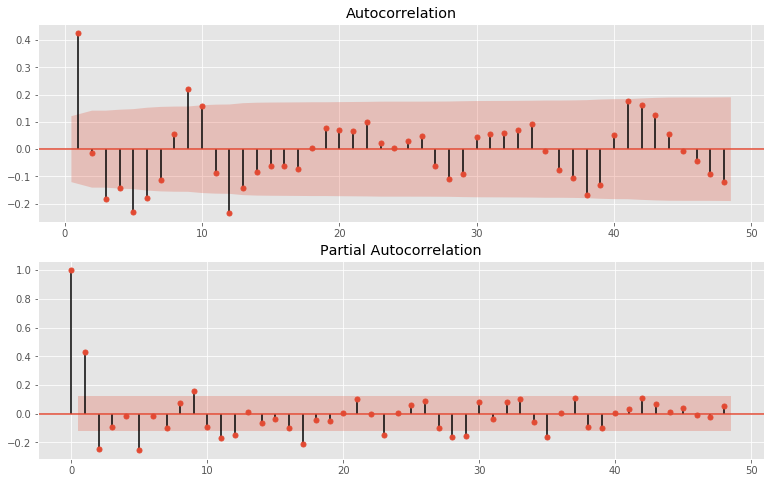

In [34]:
acf_pacf(TS_78758d)

From the plots, there is some statistically significant lags for the MA(q) at 6 and the AR(p) at 3 or 4. Now, we will check for seasonality.

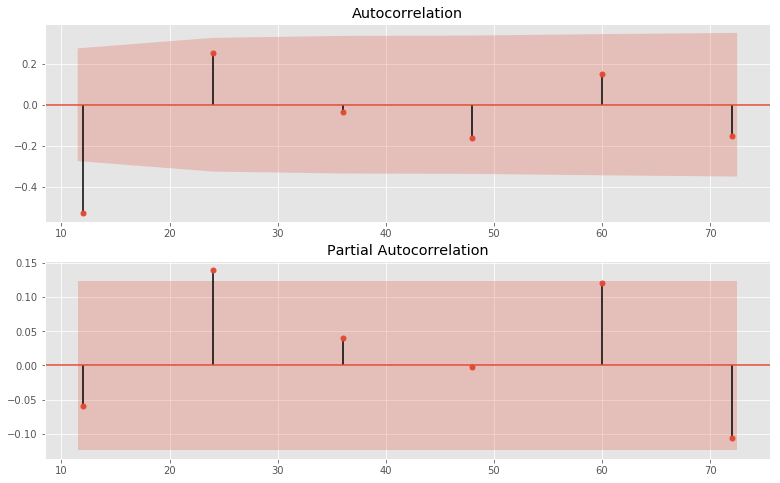

In [35]:
seasonal_plot(TS_78758d, N=13)

While there is a statistically significant lag at 12 months, there are no other significant lags at other 12 month intervals, so it is probable that there is no seasonality in the data. Now, we will find the parameter for the model.

In [36]:
results = auto_arima(TS_78758, information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=-2537.069, BIC=-2515.613, Fit time=2.130 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-1923.632, BIC=-1916.480, Fit time=0.185 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-2379.634, BIC=-2365.330, Fit time=1.296 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-2218.710, BIC=-2204.407, Fit time=1.328 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-2540.456, BIC=-2522.576, Fit time=1.616 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=-2535.116, BIC=-2520.813, Fit time=0.481 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 2, 12); AIC=-2533.430, BIC=-2511.974, Fit time=6.509 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=-2537.581, BIC=-2512.549, Fit time=7.401 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-2548.316, BIC=-2526.861, Fit time=3.947 seconds
Fit ARIMA:

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 0, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_78758,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]


The model parameters are: p = 1, d = 1, q = 1; P = 1, D = 0, Q = 0. 

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(2, 1, 1)   Log Likelihood                1150.261
Date:                Thu, 17 Oct 2019   AIC                          -2292.523
Time:                        09:46:50   BIC                          -2278.823
Sample:                    05-01-1996   HQIC                         -2286.995
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1440      0.090     12.756      0.000       0.968       1.320
ar.L2         -0.5179      0.045    -11.569      0.000      -0.606      -0.430
ma.L1         -0.7209      0.104     -6.957      0.0

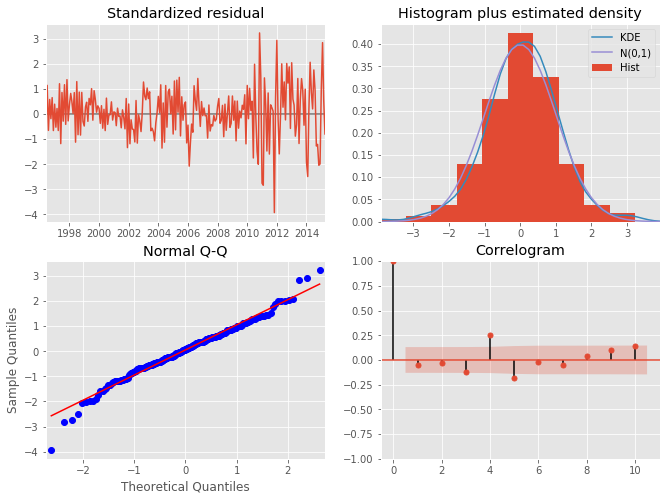

In [37]:
# fit SARIMA model
pdq = (2,1,1)
pdqs = (1,0,1,12)
train, test, results = model_fit(TS_78758, pdq=pdq, pdqs=pdqs)

One of the coefficients is not statistically significant but we can see the residuals are mostly normal with the tails in the Q-Q plot taper off. The standardized residuals also shows some white noise. 

SARIMA model RMSE on train data: 0.00210


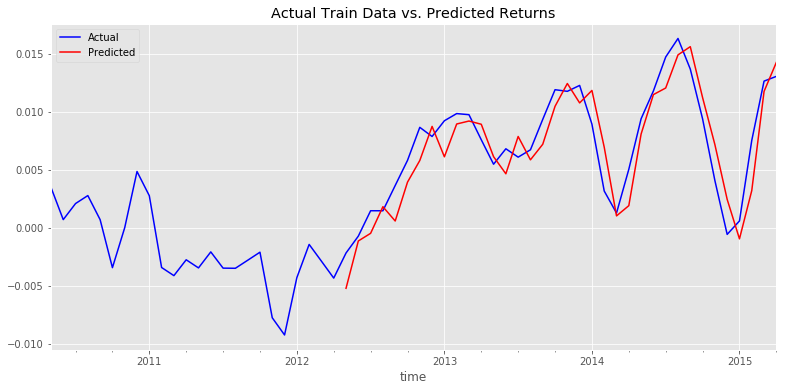

In [38]:
train_RMSE(train, results)

C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

SARIMA model RMSE on test data: 0.00365


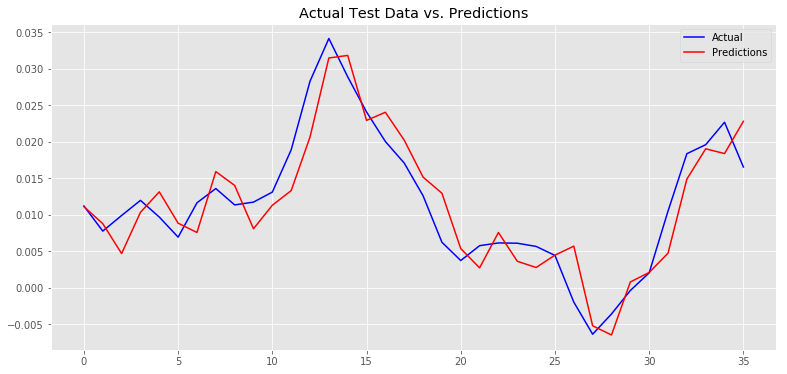

In [39]:
test_RMSE(TS_78758, pdq=pdq, pdqs=pdqs, display = True)

Similar to the previous models, the RMSEs here are small and we can see that the predicted data mirrors the actual data but is not exact. Now, we can look at forecast the future monthly returns of this model.

C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


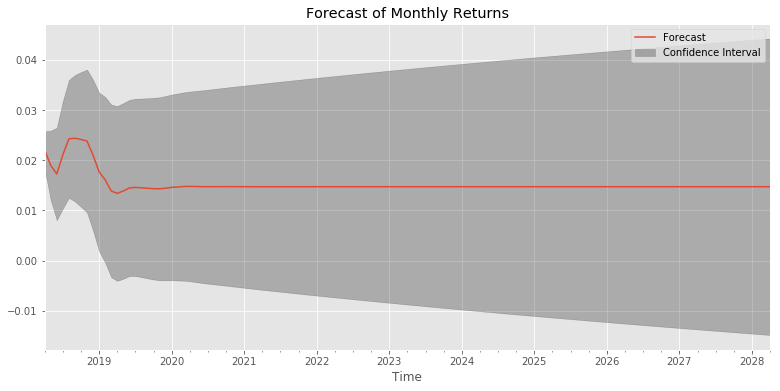

Total expected return in 1 year: 27.4%
Total expected return in 3 years: 80.2%
Total expected return in 5 year: 155.93%
Total expected return in 10 years: 524.34%


In [40]:
ret_78758 = forecast_model(TS_78758, pdq=pdq, pdqs=pdqs, zc = 78758)

## Zipcode 98444(Parkland, WA)

We will start analyzing this zipcode with differenced data due to it being non-stationary.

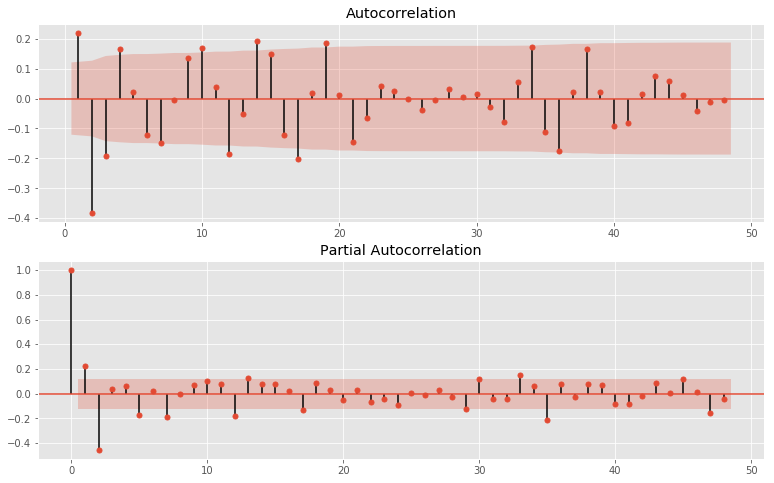

In [41]:
acf_pacf(TS_98444d)

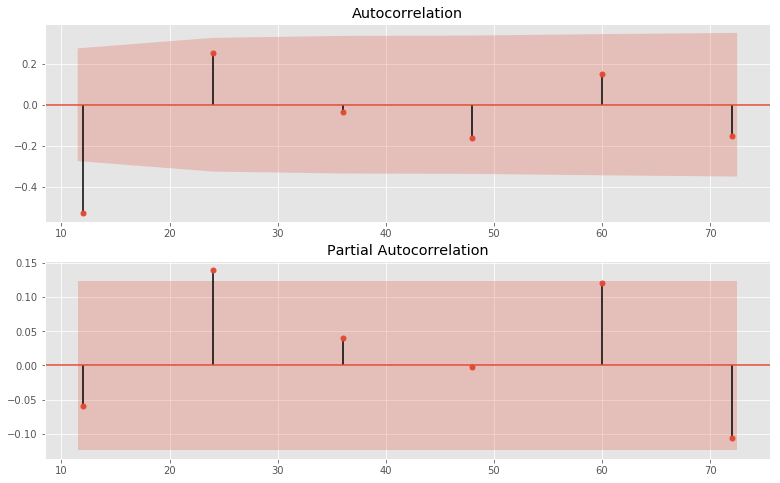

In [42]:
seasonal_plot(TS_98444d, N=13)

In [43]:
results = auto_arima(TS_98444, information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=-2475.354, BIC=-2453.898, Fit time=1.867 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-1802.200, BIC=-1795.048, Fit time=0.093 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-2265.083, BIC=-2250.779, Fit time=0.764 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-2137.669, BIC=-2123.365, Fit time=1.007 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-2469.919, BIC=-2452.039, Fit time=2.329 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 1, 12); AIC=-2471.815, BIC=-2446.783, Fit time=6.061 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=-2302.495, BIC=-2284.615, Fit time=1.646 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=-2453.850, BIC=-2428.819, Fit time=6.445 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=-2465.268, BIC=-2450.964, Fit time=0.684 seconds
Fit ARIMA:

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_98444,
                                            order=comb,
                                            seasonal_order=combs,
                                            simple_differencing=True,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]


                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1067.201
Date:                Thu, 17 Oct 2019   AIC                          -2128.402
Time:                        09:49:25   BIC                          -2118.127
Sample:                    05-01-1996   HQIC                         -2124.256
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0462      0.146     -0.317      0.751      -0.332       0.239
ma.L1          0.3716      0.141      2.630      0.009       0.095       0.649
sigma2       4.81e-06    2.8e-07     17.185      0.0

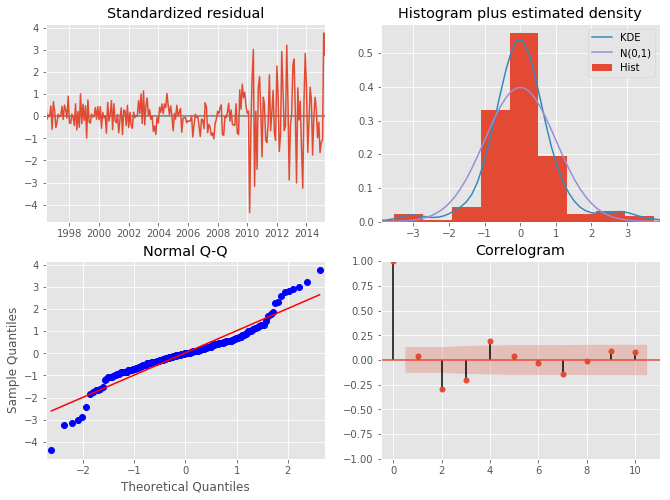

In [44]:
pdq = (1,1,1)
pdqs = (1,0,1,12)
train, test, results = model_fit(TS_98444, pdq=pdq, pdqs=pdqs)

SARIMA model RMSE on train data: 0.00388


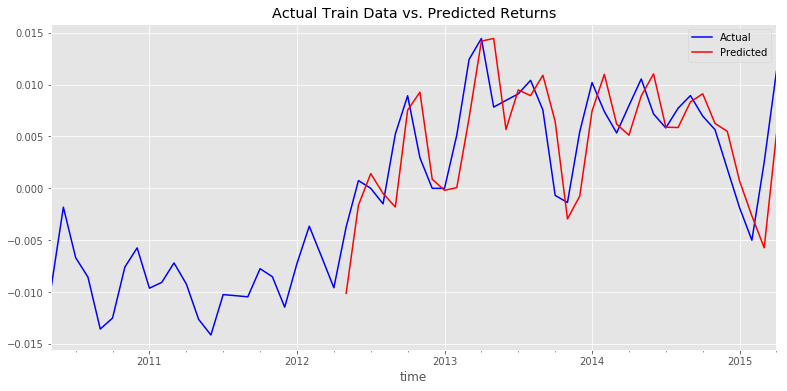

In [45]:
train_RMSE(train, results)

In [46]:
test_RMSE(TS_98444, pdq=pdq, pdqs=pdqs, display = True)

C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


LinAlgError: Non-positive-definite forecast error covariance matrix encountered at period 1

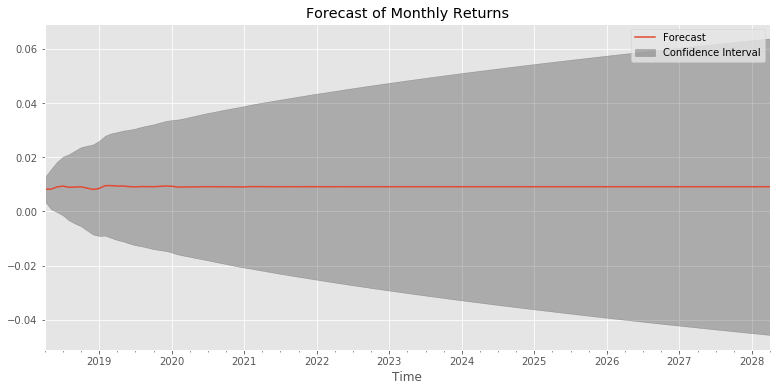

Total expected return in 1 year: 11.12%
Total expected return in 3 years: 38.22%
Total expected return in 5 year: 71.84%
Total expected return in 10 years: 198.78%


In [47]:
ret_98444 = forecast_model(TS_98444, pdq=pdq, pdqs=pdqs, zc = 98444)

## Zipcode 37214(Nashville, TN)

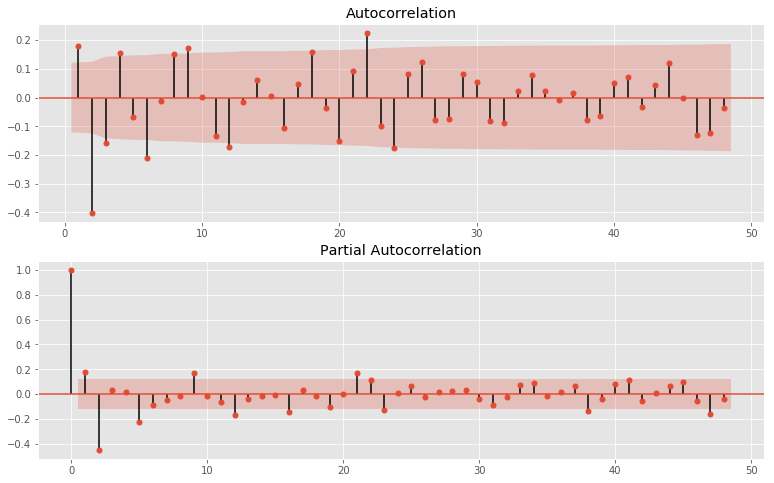

In [48]:
acf_pacf(TS_37214d)

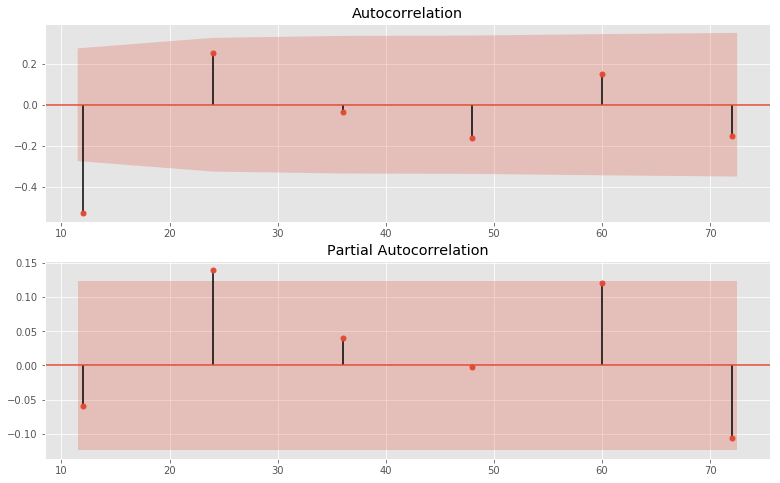

In [49]:
seasonal_plot(TS_37214d, N=13)

In [50]:
results = auto_arima(TS_37214, information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=-2494.558, BIC=-2473.102, Fit time=2.212 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-2032.757, BIC=-2025.605, Fit time=0.121 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-2389.901, BIC=-2375.597, Fit time=1.067 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-2356.343, BIC=-2342.039, Fit time=2.270 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-2582.985, BIC=-2565.105, Fit time=1.722 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=-2574.054, BIC=-2559.750, Fit time=0.297 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 2, 12); AIC=-2588.571, BIC=-2567.116, Fit time=5.821 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 2, 12); AIC=-2375.679, BIC=-2357.799, Fit time=5.640 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 2, 12); AIC=-2560.339, BIC=-2535.307, Fit time=12.545 seconds
Fit ARIMA

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 2, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_37214,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
for param in pdq:
    for param_seasonal in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_37214,
                                           order=param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC: {}'.format(param, seasonal_param, results.aic))
        except:
            continue

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 1, 3)   Log Likelihood                1143.963
Date:                Thu, 17 Oct 2019   AIC                          -2277.926
Time:                        09:52:30   BIC                          -2260.801
Sample:                    05-01-1996   HQIC                         -2271.016
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0986      0.292     -0.338      0.735      -0.671       0.473
ma.L1          0.2618      0.295      0.889      0.374      -0.315       0.839
ma.L2         -0.4037      0.067     -6.004      0.0

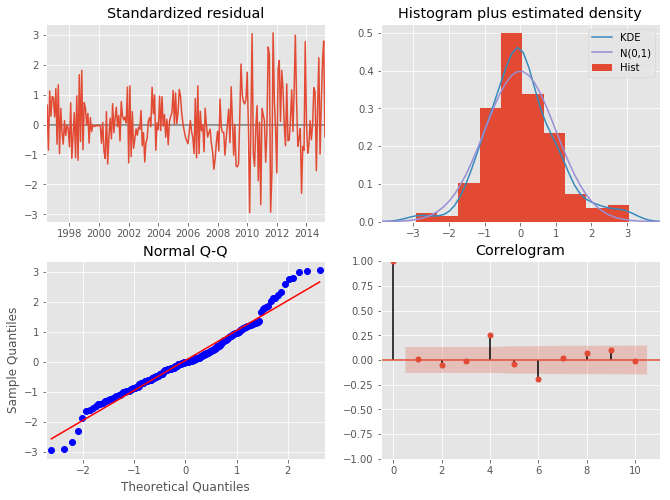

In [51]:
pdq = (1,1,3)
pdqs = (0,0,2,12)
train, test, results = model_fit(TS_37214, pdq=pdq, pdqs=pdqs)

SARIMA model RMSE on train data: 0.00203


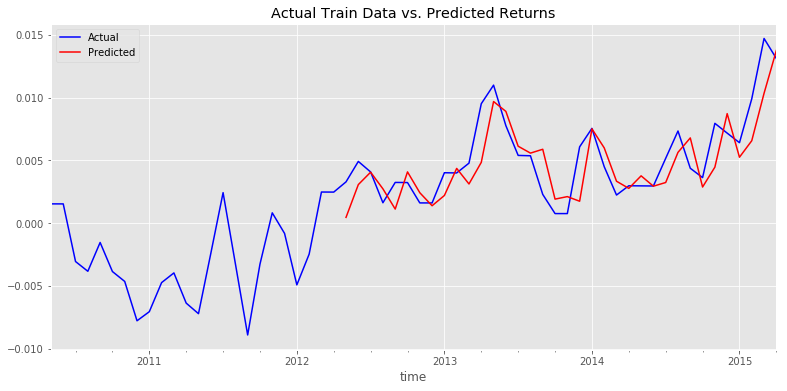

In [52]:
train_RMSE(train, results)

C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

SARIMA model RMSE on test data: 0.00233


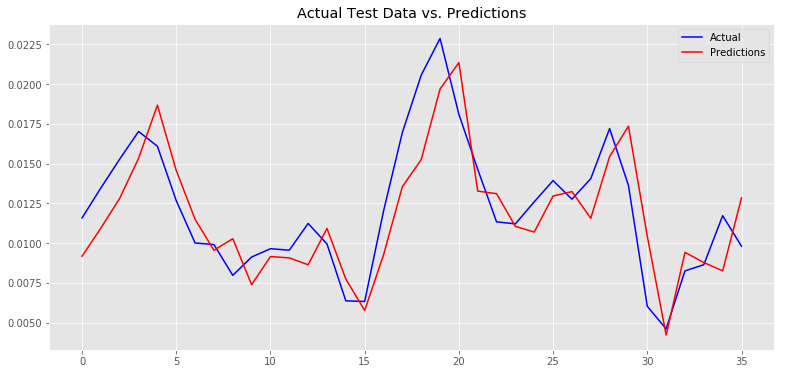

In [53]:
test_RMSE(TS_37214, pdq=pdq, pdqs=pdqs, display = True)

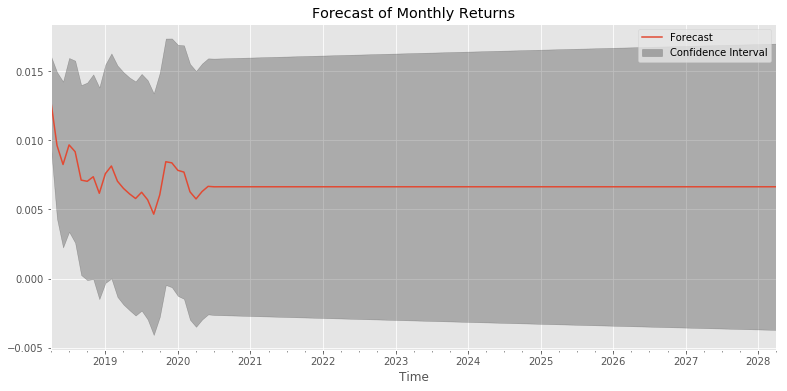

Total expected return in 1 year: 10.48%
Total expected return in 3 years: 29.37%
Total expected return in 5 year: 51.66%
Total expected return in 10 years: 127.18%


In [54]:
ret_37214 = forecast_model(TS_37214, pdq=pdq, pdqs=pdqs, zc = 37214)

## Findings

After performing time series analyses on the five zipcodes and forecasting the returns up to ten years, I would recommend the real estate investment company to invest in the top three zipcodes:
1. 78758(Austin, TX) <br>
2. 98444(Parkland, WA) <br>
3. 80631 (Greeley, CO) <br>

The other two zipcodes do not have as high returns as the top three.

In [55]:
# put the future returns in a dataframe
tot_returns = [ret_37214, ret_98444, ret_78758, ret_80631, ret_97233]
tot_returns = pd.DataFrame(tot_returns, columns=['ZipCode', '1-year', '3-year', '5-year', '10-year'])
tot_returns.sort_values('10-year', ascending=False)

,ZipCode,1-year,3-year,5-year,10-year
2,78758,0.273967,0.801996,1.559342,5.243408
3,80631,0.188212,0.659334,1.319091,4.430931
1,98444,0.111154,0.382239,0.718386,1.987814
0,37214,0.104798,0.293667,0.516595,1.271772
4,97233,0.080927,0.263230,0.476280,1.193837


These forecasts are based on historic monthly returns, and past performance does not necessarily predict future results. 

# Future Work

These models can be improved by taking other external varaibles into account. These other variables can include tax rates, crime rates, school district ratings and interest rates.
It may to interesting to compare a time series analysis on just housing prices and the monthly returns discovered in this analysis. The results from both would improve the decision making process.